In [1]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph



In [2]:
import os
import optuna
from optuna.trial import TrialState
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/Users/ramrap/miniconda/envs/btp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data prep

In [3]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('./Data/grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [4]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    # df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.lat >= lat_range['min']) & (df.lat <= lat_range['max']) & (df.long >= long_range['min']) & (df.long <= long_range['max'])]

    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','temperature','humidity','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')[['pm2_5', 'temperature', 'humidity']]   
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [5]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [6]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    print(max_pm, min_pm)
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [7]:
from ctypes import sizeof


def sequence_data_preparation(seq_len, pre_len, train_data_pm2_5, train_data_temp, train_data_hum, test_data_pm2_5, test_data_temp, test_data_hum):
    trainX, trainY, testX, testY = [], [], [], []
    
    for i in range(train_data_pm2_5.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data_pm2_5[:, i : i + seq_len + pre_len]
        b = train_data_temp[:, i : i + seq_len + pre_len]
        c = train_data_hum[:, i : i + seq_len + pre_len]
        
        # d is dataframe 
        d = pd.DataFrame()
        for i in range(seq_len):
            d = pd.concat([d, pd.DataFrame(a[:,i])], axis=1)
            d = pd.concat([d, pd.DataFrame(b[:,i])], axis=1)
            d = pd.concat([d, pd.DataFrame(c[:,i])], axis=1)
            
        
        
        
        # d = np.concatenate((a[:, :seq_len] , b[:, :seq_len] , c[:, :seq_len]), axis=1)
       
        
     
        
        
        
        trainX.append(d)
        trainY.append(a[:, -1])

    for i in range(test_data_pm2_5.shape[1] - int(seq_len + pre_len - 1)):
        a = test_data_pm2_5[:, i : i + seq_len + pre_len]
        b = test_data_temp[:, i : i + seq_len + pre_len]
        c = test_data_hum[:, i : i + seq_len + pre_len]
        d = pd.DataFrame()
        for i in range(seq_len):
            d = pd.concat([d, pd.DataFrame(a[:,i])], axis=1)
            d = pd.concat([d, pd.DataFrame(b[:,i])], axis=1)
            d = pd.concat([d, pd.DataFrame(c[:,i])], axis=1)
        # d = np.concatenate((a[:, :seq_len] , b[:, :seq_len] , c[:, :seq_len]), axis=1)
        testX.append(d)
        testY.append(a[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)
    
    

    
    

    # print(trainX)

    return trainX, trainY, testX, testY

# train_size = 0.86
# train_data_pm2_5, test_data_pm2_5 = train_test_split(df_pm2_5, grid_points_indices, train_size)
# train_data_temp, test_data_temp = train_test_split(df_temp, grid_points_indices, train_size)
# train_data_hum, test_data_hum = train_test_split(df_hum, grid_points_indices, train_size)

# train_scaled_pm2_5, test_scaled_pm2_5 = scale_data(train_data_pm2_5, test_data_pm2_5)
# train_scaled_temp, test_scaled_temp = scale_data(train_data_temp, test_data_temp)
# train_scaled_hum, test_scaled_hum = scale_data(train_data_hum, test_data_hum)

# trainX, trainY, testX, testY = sequence_data_preparation(
#     seq_len, pre_len, train_scaled_pm2_5, train_scaled_temp, train_scaled_hum, test_scaled_pm2_5, test_scaled_temp, test_scaled_hum)

# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)

In [8]:
def prepare_train_data(grid_points_indices, train_size = 0.8):
    train_data_pm2_5, test_data_pm2_5 = train_test_split(df_pm2_5, grid_points_indices, train_size)
    train_data_temp, test_data_temp = train_test_split(df_temp, grid_points_indices, train_size)
    train_data_hum, test_data_hum = train_test_split(df_hum, grid_points_indices, train_size)

    train_scaled_pm2_5, test_scaled_pm2_5 = scale_data(train_data_pm2_5, test_data_pm2_5)
    train_scaled_temp, test_scaled_temp = scale_data(train_data_temp, test_data_temp)
    train_scaled_hum, test_scaled_hum = scale_data(train_data_hum, test_data_hum)

    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled_pm2_5, train_scaled_temp, train_scaled_hum, test_scaled_pm2_5, test_scaled_temp, test_scaled_hum)

    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data_pm2_5

# Training

In [9]:
def my_loss(y_true, y_pred):
    a = y_pred[y_true > 0] - y_true[y_true > 0]
    return torch.sum(a**2), len(a)

In [10]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [11]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [12]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [13]:
# collect data for the whole three months, clean it and store it in a csv file
# df = pd.DataFrame()
# months = ['Nov', 'Dec', 'Jan']
# month_code = ['11', '12', '01']
# year = ['2020', '2020', '2021']
# for i in range(3):
#     x = '../dataset/%s/%s-%s-' % (months[i], year[i], month_code[i])
#     for day in range(1, 32):
#         file = '%s%s_all.csv' % (x, day)
#         # check if file exists
#         print(file)
#         if(os.path.isfile(file)):
#             df1 = data_preparation(file)
#             df = pd.concat([df, df1], axis=1)
# df.fillna(0, inplace=True)
# # dump the data in pickle
# df.to_pickle('../dataset/df.pkl')

In [14]:
df = pd.read_pickle('./df.pkl')

In [15]:
df_pm2_5 = df['pm2_5']
df_temp = df['temperature']
df_hum = df['humidity']

print("df_pm2_5", df_pm2_5)
# for i in df_pm2_5:
#     print(i)
print("temp",df_temp)

df_pm2_5 dateTime                  360         540         720        900         1080  \
lat_grid long_grid                                                              
0        21           0.000000    0.000000    0.000000   0.000000    0.000000   
         22         502.792722  392.439383  135.177801  79.938086  100.638132   
1        19           0.000000    0.000000    0.000000   0.000000    0.000000   
         20           0.000000    0.000000    0.000000   0.000000    0.000000   
         21         497.476190  419.319149  166.090909  80.000000  108.244898   
...                        ...         ...         ...        ...         ...   
23       8            0.000000    0.000000    0.000000   0.000000    0.000000   
         13           0.000000    0.000000    0.000000   0.000000    0.000000   
24       7            0.000000    0.000000    0.000000   0.000000    0.000000   
         8            0.000000    0.000000    0.000000   0.000000    0.000000   
         13        

In [16]:
trainX, trainY, testX, testY, train_data = prepare_train_data(grid_points_indices, train_size = 0.86)

887.4905660377359 0.0
185.42000000000004 0.0
100.0 0.0
(440, 270, 9)
(440, 270)
(70, 270, 9)
(70, 270)


In [17]:
from gcn_lstm import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 9, gc_sizes = [32,16,8], lstm_sizes = [8,4])
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-05)

2022-09-13 18:32:02.061384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([270, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([270])


In [19]:

def train_model(model, optimizer, trainX, trainY, testX, testY, n_epochs, batch_size):
    # convert all data to tensor
    trainX = torch.from_numpy(trainX.astype(np.float32))
    trainY = torch.from_numpy(trainY.astype(np.float32))
    testX = torch.from_numpy(testX.astype(np.float32))
    testY = torch.from_numpy(testY.astype(np.float32))
    
    trainDs = TensorDataset(trainX, trainY)
    testDs = TensorDataset(testX, testY)
    trainLoader = DataLoader(trainDs, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batch_size, shuffle=False)

    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_len = 0
        valid_len = 0
        for _, (inputs, targets) in enumerate(trainLoader):
            model.train()
            outputs = model(inputs)
            loss, tlen = my_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_len += tlen
        
        with torch.no_grad():
            for _, (inputs, targets) in enumerate(testLoader):
                model.eval()
                outputs = model(inputs)
                loss, tlen = my_loss(outputs, targets)
                valid_loss += loss.item()
                valid_len += tlen

        train_loss /= train_len
        valid_loss /= valid_len
        train_mse.append(train_loss)
        validation_mse.append(valid_loss)
        train_rmse.append(math.sqrt(train_loss))
        validation_rmse.append(math.sqrt(valid_loss))

        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {train_loss}, 'Valid Loss: ', {valid_loss})

    return train_mse, train_rmse, validation_mse, validation_rmse

Epoch 10 	 Train Loss:  {0.019609363889854764} Valid Loss:  {0.011228800374994833}
Epoch 20 	 Train Loss:  {0.013048324263858473} Valid Loss:  {0.007223876317342123}
Epoch 30 	 Train Loss:  {0.011029848073066686} Valid Loss:  {0.006440571981763083}
Epoch 40 	 Train Loss:  {0.010327778247871785} Valid Loss:  {0.006159504885395998}
Epoch 50 	 Train Loss:  {0.009760551773739181} Valid Loss:  {0.00603054990213384}
Epoch 60 	 Train Loss:  {0.00950961035911483} Valid Loss:  {0.005962642033894857}
Epoch 70 	 Train Loss:  {0.009375810125460127} Valid Loss:  {0.005919065324086992}
Epoch 80 	 Train Loss:  {0.009304346283678254} Valid Loss:  {0.0059053912490763995}
Epoch 90 	 Train Loss:  {0.009204625794381806} Valid Loss:  {0.005907945077886026}
Epoch 100 	 Train Loss:  {0.009121080343972151} Valid Loss:  {0.005906179518926712}


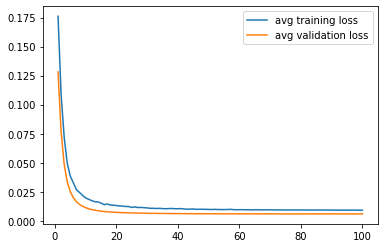

In [20]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 20)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()

In [21]:
trainY[0]

array([0.        , 0.09007204, 0.        , 0.        , 0.0901418 ,
       0.09168873, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10074794, 0.07605715, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08018865, 0.09328407, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08869089, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08768104, 0.08910171,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09933627, 0.08509181, 0.08647559, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09475133,
       0.09417279, 0.08492809, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [22]:
predY0 = model(torch.tensor(trainX[0]).float().unsqueeze(0))

In [23]:
predY0

tensor([[0.0126, 0.2124, 0.0961, 0.0972, 0.1990, 0.2013, 0.0096, 0.0102, 0.0117,
         0.0134, 0.0941, 0.0110, 0.2043, 0.0843, 0.0097, 0.0137, 0.0093, 0.0123,
         0.0857, 0.0905, 0.1907, 0.2017, 0.0138, 0.0114, 0.0116, 0.0125, 0.0963,
         0.0104, 0.2005, 0.0114, 0.0117, 0.0427, 0.0364, 0.0092, 0.0116, 0.0105,
         0.0948, 0.0966, 0.2013, 0.1975, 0.0092, 0.0119, 0.0466, 0.0549, 0.0570,
         0.0533, 0.0124, 0.0111, 0.0117, 0.0129, 0.1901, 0.1997, 0.2021, 0.0665,
         0.0738, 0.0108, 0.0501, 0.0570, 0.0103, 0.0111, 0.0588, 0.0124, 0.0140,
         0.0112, 0.1951, 0.1991, 0.1993, 0.0596, 0.0689, 0.0729, 0.0507, 0.0506,
         0.1656, 0.1726, 0.1733, 0.1801, 0.1798, 0.1875, 0.1949, 0.1973, 0.1981,
         0.1702, 0.1447, 0.0694, 0.0400, 0.0422, 0.1741, 0.0095, 0.0118, 0.0108,
         0.1335, 0.1521, 0.1579, 0.1858, 0.0278, 0.1725, 0.1584, 0.1729, 0.1643,
         0.0121, 0.0129, 0.0117, 0.1295, 0.1299, 0.1236, 0.1902, 0.0633, 0.1643,
         0.0284, 0.0114, 0.1

Epoch 10 	 Train Loss:  {0.00911008985757025} Valid Loss:  {0.005904540914707083}
Epoch 20 	 Train Loss:  {0.008985491312714138} Valid Loss:  {0.005909752366404054}
Epoch 30 	 Train Loss:  {0.008982046557596638} Valid Loss:  {0.005930571934533497}
Epoch 40 	 Train Loss:  {0.008936646169283574} Valid Loss:  {0.0059235669696141805}
Epoch 50 	 Train Loss:  {0.008998157183329265} Valid Loss:  {0.005944879319932725}
Epoch 60 	 Train Loss:  {0.008994073466419773} Valid Loss:  {0.005949449438266653}
Epoch 70 	 Train Loss:  {0.008983596727904246} Valid Loss:  {0.005941995893205915}
Epoch 80 	 Train Loss:  {0.008914241325172913} Valid Loss:  {0.0059426001896933905}
Epoch 90 	 Train Loss:  {0.008877958239931049} Valid Loss:  {0.005941032732605303}
Epoch 100 	 Train Loss:  {0.008954943791784421} Valid Loss:  {0.0059423314957391645}


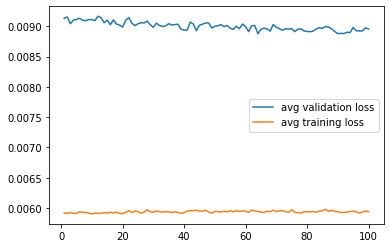

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,84.202539,83.983734,68.393092,68.413559


In [24]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 20)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.008860568618934965} Valid Loss:  {0.005923697109575625}
Epoch 20 	 Train Loss:  {0.008942458432932895} Valid Loss:  {0.005920341317615812}
Epoch 30 	 Train Loss:  {0.008921467559506195} Valid Loss:  {0.00592324833390574}
Epoch 40 	 Train Loss:  {0.00890937515782186} Valid Loss:  {0.0059254628514486644}
Epoch 50 	 Train Loss:  {0.008936127697177207} Valid Loss:  {0.00594114310526974}
Epoch 60 	 Train Loss:  {0.008897683837197044} Valid Loss:  {0.005908262407968915}
Epoch 70 	 Train Loss:  {0.008934875786906542} Valid Loss:  {0.00594542767004992}
Epoch 80 	 Train Loss:  {0.008900287524618284} Valid Loss:  {0.005934463499715089}
Epoch 90 	 Train Loss:  {0.008895778527564874} Valid Loss:  {0.005921622811171113}
Epoch 100 	 Train Loss:  {0.008857742608195603} Valid Loss:  {0.005923581962232236}


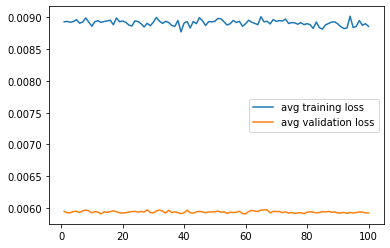

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,83.786191,83.52669,68.386422,68.305543


In [25]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model,optimizer, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)